# Assignment 1 Part 2.6

## Import necessary modules

In [1]:
import torch
import torch.nn as nn
import os
import mlflow
from datetime import datetime
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

## CNN Layer class: Modified
* Added batch normalization
* Added dropout
* Added weight decay and weight initialization

In [2]:
class CNNLayer(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_rate=0.5, weight_decay=1e-5):
        '''
        Initialize the CNNLayer class
        
        Parameters:
            input_channels (int): number of channels in the input image
            num_classes (int): number of classes in the output
        '''
        super(CNNLayer, self).__init__()

        # define the convolutional layers
        self.conv_layer = nn.Sequential(
            # create the first convolutional layer
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1),
            # add a ReLU activation function which is recommended for CNNs
            nn.ReLU(),
            # add a batch normalization layer
            nn.BatchNorm2d(32), 
            # add a max pooling layer which reduces the size of the image by half
            nn.MaxPool2d(kernel_size=2, stride=2),
            # add a dropout layer to prevent overfitting
            nn.Dropout2d(p=dropout_rate/2),

            # create the second convolutional layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_rate/2)
        )
        
        # calculate the size of the flattened layer
        # after the convolutional layer, the image is reduced to 64x7x7
        flattened_size = 64 * 7 * 7

        # define the fully connected layer
        self.fc_layer = nn.Sequential(
            nn.Flatten(), # flatten the image from 3d to 1d
            nn.Linear(flattened_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

        self.weight_decay = weight_decay

        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(module.bias, 0)
                    
    def forward(self, inputs):
        '''
        Forward pass of the CNNLayer
        
        Parameters:
            inputs (torch.Tensor): the input image
        '''

        # pass the inputs through the convolutional layer
        outputs = self.conv_layer(inputs)

        # pass the outputs through the fully connected layer
        outputs = self.fc_layer(outputs)

        return outputs



## Trainer class

In [3]:
class Trainer:
    def __init__(self,
                 model,
                 criterion,
                 optimizer,
                 train_loader,
                 val_loader=None,
                 test_loader=None,
                 device=None,
                 scheduler=None,
                 checkpoint_dir='./checkpoints',
                 experiment_name=None):
        """
        Initialize the trainer with model, criterion, optimizer, and data loaders

        Parameters:
            model: nn.Module
                The model to train
            criterion: loss function
                The loss function to use
            optimizer: torch.optim
                The optimizer to use
            train_loader: DataLoader
                The data loader for training data
            val_loader: DataLoader
                The data loader for validation data
            test_loader: DataLoader
                The data loader for test data
            device: torch.device
                The device to use for training
            scheduler: torch.optim.lr_scheduler
                Learning rate scheduler (optional)
            checkpoint_dir: str
                Directory to save checkpoints
            experiment_name: str
                Name of the experiment for MLflow tracking
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader if val_loader is not None else test_loader
        self.test_loader = test_loader
        self.device = device if device is not None else torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.scheduler = scheduler
        self.checkpoint_dir = checkpoint_dir
        self.experiment_name = experiment_name
        self.input_size = None  # will be set during first forward pass
        self.is_cnn = isinstance(self.model, CNNLayer)

        # create checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)

        # move model to device
        self.model.to(self.device)

        # initialize training metrics
        self.best_accuracy = 0.0
        self.best_loss = float('inf')
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': [],
            'learning_rates': [],
            'epoch_times': []  # add tracking of per-epoch times
        }
        
        # initialize performance tracking
        self.total_training_time = 0
        self.epoch_start_time = 0
        self.total_epochs_completed = 0

    def train_epoch(self, epoch, num_epochs):
        """
        Train the model for one epoch
        """
        # start timing the epoch
        self.epoch_start_time = time.time()
        
        self.model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(self.train_loader):
            # get input size from first batch if not set
            if self.input_size is None and hasattr(inputs, 'view'):
                self.input_size = inputs.view(inputs.size(0), -1).size(1)

            # prepare inputs
            if not self.is_cnn and hasattr(inputs, 'view'):
                # for image data, flatten if needed
                inputs = inputs.view(inputs.size(0), -1).to(self.device)
            else:
                inputs = inputs.to(self.device)

            labels = labels.to(self.device)

            # forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # update statistics
            running_loss += loss.detach().item()

            # print progress
            if (i+1) % 100 == 0:
                print(
                    f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.train_loader)}], Loss: {loss.detach().item():.4f}')

        # calculate average loss for the epoch
        epoch_loss = running_loss / len(self.train_loader)
        self.history['train_loss'].append(epoch_loss)

        # track learning rate
        current_lr = self.optimizer.param_groups[0]['lr']
        self.history['learning_rates'].append(current_lr)
        
        # calculate and store epoch time
        epoch_time = time.time() - self.epoch_start_time
        self.history['epoch_times'].append(epoch_time)
        self.total_training_time += epoch_time
        self.total_epochs_completed += 1
        
        # print epoch time
        print(f'Epoch time: {epoch_time:.2f} seconds')

        return epoch_loss

    def validate(self, epoch=None):
        """
        Validate the model on validation data
        """
        if self.val_loader is None:
            return None, None

        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                # prepare inputs
                if not self.is_cnn and hasattr(inputs, 'view'):
                    # for image data
                    inputs = inputs.view(inputs.size(0), -1).to(self.device)
                else:
                    inputs = inputs.to(self.device)

                labels = labels.to(self.device)

                # forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # update statistics
                running_loss += loss.item()

                # calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # calculate average loss and accuracy
        val_loss = running_loss / len(self.val_loader)
        val_accuracy = 100 * correct / total

        if epoch is not None:
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)

        return val_loss, val_accuracy

    def test(self):
        """
        Test the model on test data
        """
        if self.test_loader is None:
            return None, None

        return self.validate()  # reuse validation code for testing

    def save_checkpoint(self, epoch, train_loss, val_loss=None, val_accuracy=None, is_best=False):
        """
        Save a checkpoint of the model
        """
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': train_loss
        }

        if val_loss is not None:
            checkpoint['val_loss'] = val_loss

        if val_accuracy is not None:
            checkpoint['val_accuracy'] = val_accuracy

        if self.scheduler is not None:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        # save regular checkpoint
        checkpoint_path = os.path.join(
            self.checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save(checkpoint, checkpoint_path)

        # save as best model if applicable
        if is_best:
            best_model_path = os.path.join(
                self.checkpoint_dir, 'best_model.pt')
            torch.save(checkpoint, best_model_path)
            print(f'New best model saved with accuracy: {val_accuracy:.2f}%')

        return checkpoint_path

    def load_checkpoint(self, checkpoint_path):
        """
        Load a checkpoint
        """
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if 'scheduler_state_dict' in checkpoint and self.scheduler is not None:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch']
        loss = checkpoint.get('loss', 0)
        val_loss = checkpoint.get('val_loss', 0)
        val_accuracy = checkpoint.get('val_accuracy', 0)

        print(
            f"Checkpoint loaded - Epoch: {start_epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        return start_epoch

    def train(self, num_epochs, start_epoch=0, log_to_mlflow=True, early_stopping_patience=None):
        """
        Train the model for multiple epochs

        Parameters:
            num_epochs: int
                Number of epochs to train for
            start_epoch: int
                Starting epoch (useful when resuming training)
            log_to_mlflow: bool
                Whether to log metrics to MLflow
            early_stopping_patience: int
                Number of epochs to wait for improvement before stopping
        """
        # start timer for total training run
        total_run_start_time = time.time()
        
        # reset performance tracking for a new training run
        if start_epoch == 0:
            self.total_training_time = 0
            self.total_epochs_completed = 0
            
        # set mlflow experiment if provided
        if log_to_mlflow and self.experiment_name:
            mlflow.set_experiment(self.experiment_name)

        # initialize early stopping variables
        if early_stopping_patience is not None:
            early_stopping_counter = 0
            best_val_loss = float('inf')

        # start mlflow run if applicable
        run_context = mlflow.start_run(
            run_name=f"{self.model.__class__.__name__}_{datetime.now().strftime('%Y%m%d_%H%M%S')}") if log_to_mlflow else DummyContextManager()

        # store previous learning rate to detect changes
        prev_lr = self.optimizer.param_groups[0]['lr']

        with run_context:
            # log parameters if using mlflow
            if log_to_mlflow:
                params = {
                    "optimizer": self.optimizer.__class__.__name__,
                    "learning_rate": self.optimizer.param_groups[0]['lr'],
                    "num_epochs": num_epochs
                }
                # add model architecture params if available
                if hasattr(self.model, 'input_size'):
                    params["input_size"] = self.model.input_size
                mlflow.log_params(params)

            print("Starting training...")
            for epoch in range(start_epoch, num_epochs):
                # train for one epoch
                print('')
                train_loss = self.train_epoch(epoch, num_epochs)
                print(
                    f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

                # validate
                val_loss, val_accuracy = self.validate(epoch)

                # early stopping check for overfitting
                if early_stopping_patience is not None and val_loss is not None:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                        print(
                            f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')

                        if early_stopping_counter >= early_stopping_patience:
                            print(
                                f'Early stopping triggered after epoch {epoch+1}')
                            break

                # log metrics
                if log_to_mlflow:
                    mlflow.log_metric("train_loss", train_loss, step=epoch)
                    mlflow.log_metric("epoch_time", self.history['epoch_times'][-1], step=epoch)
                    if val_loss is not None:
                        mlflow.log_metric("val_loss", val_loss, step=epoch)
                    if val_accuracy is not None:
                        mlflow.log_metric(
                            "val_accuracy", val_accuracy, step=epoch)

                # print validation results
                if val_loss is not None and val_accuracy is not None:
                    print(
                        f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

                # check if this is the best model so far
                is_best = False
                if val_accuracy is not None and val_accuracy > self.best_accuracy:
                    self.best_accuracy = val_accuracy
                    is_best = True

                # save checkpoint
                self.save_checkpoint(
                    epoch, train_loss, val_loss, val_accuracy, is_best)

                # update learning rate if scheduler is provided
                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(val_loss)
                    else:
                        self.scheduler.step()

                 # check if learning rate changed
                current_lr = self.optimizer.param_groups[0]['lr']
                if current_lr != prev_lr:
                    print(
                        f"Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
                    prev_lr = current_lr

            # calculate total run time
            total_run_time = time.time() - total_run_start_time
            
            print("Training complete!")

            
            # print performance summary
            print("\nTraining Performance Summary:")
            print(f"Total training time: {total_run_time:.2f} seconds ({total_run_time/60:.2f} minutes)")
            print(f"Total epochs completed: {self.total_epochs_completed}")
            print(f"Average time per epoch: {self.total_training_time/self.total_epochs_completed:.2f} seconds")
            print(f"Fastest epoch: {min(self.history['epoch_times']):.2f} seconds")
            print(f"Slowest epoch: {max(self.history['epoch_times']):.2f} seconds")
            
            # log performance metrics to MLflow
            if log_to_mlflow:
                mlflow.log_metric("total_training_time", total_run_time)
                mlflow.log_metric("avg_epoch_time", self.total_training_time/self.total_epochs_completed)
                mlflow.log_metric("fastest_epoch_time", min(self.history['epoch_times']))
                mlflow.log_metric("slowest_epoch_time", max(self.history['epoch_times']))

            # final evaluation
            print("\nFinal Evaluation:")
            test_loss, test_accuracy = self.test()
            if test_loss is not None and test_accuracy is not None:
                print(f'Final Test Loss: {test_loss:.4f}')
                print(f'Final Test Accuracy: {test_accuracy:.2f}%')

                # log final metrics
                if log_to_mlflow:
                    mlflow.log_metric("test_loss", test_loss)
                    mlflow.log_metric("test_accuracy", test_accuracy)

            # save the final model
            model_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            final_model_path = os.path.join(
                self.checkpoint_dir, f"final_model_{model_timestamp}.pt")
            torch.save(self.model.state_dict(), final_model_path)
            print(f"Final model saved as {final_model_path}")

            # log the model with mlflow
            if log_to_mlflow:

                model_to_log = self.model.to('cpu')

                sample_batch = next(iter(self.train_loader))[0][:1]

                if self.is_cnn:
                    # for cnn, use the first batch of the training data
                    sample_input = sample_batch.numpy()
                else:
                    # for fnn, use the first batch of the training data
                    sample_input = sample_batch.view(sample_batch.size(0), -1).numpy()

                # create custom pip requirements
                pip_requirements = [
                    f"torch=={torch.__version__}",
                    "torchvision",
                    "mlflow"
                ]

                # log the model
                mlflow.pytorch.log_model(
                    model_to_log,
                    "model",
                    input_example=sample_input,
                    pip_requirements=pip_requirements
                )

                # move the model back to the original device
                self.model = self.model.to(self.device)

            # plot and save training curves
            self.plot_training_curves()

            return self.history

    def plot_training_curves(self):
        """
        plot and save the training curves
        """
        if len(self.history['train_loss']) == 0:
            return

        # create plots directory
        plots_dir = os.path.join(self.checkpoint_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)

        # plot training and validation loss
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.history['train_loss']) + 1)
        plt.plot(epochs, self.history['train_loss'],
                 'b-', label='Training Loss')

        if len(self.history['val_loss']) > 0:
            plt.plot(epochs, self.history['val_loss'],
                     'r-', label='Validation Loss')

        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(plots_dir, 'loss_curves.png')) # save the plot as a png file
        plt.tight_layout()
        plt.show()

        # plot validation accuracy if available
        if len(self.history['val_accuracy']) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, self.history['val_accuracy'], 'g-')
            plt.title('Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy (%)')
            plt.grid(True)
            plt.savefig(os.path.join(plots_dir, 'accuracy_curve.png')) # save the plot as a png file
            plt.tight_layout()
            plt.show()
            
        # plot epoch times
        if len(self.history['epoch_times']) > 0:
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, self.history['epoch_times'], 'm-')
            plt.title('Epoch Training Times')
            plt.xlabel('Epoch')
            plt.ylabel('Time (seconds)')
            plt.grid(True)
            plt.savefig(os.path.join(plots_dir, 'epoch_times.png')) # save the plot as a png file
            plt.tight_layout()
            plt.show()


# helper class for context management when not using mlflow
class DummyContextManager:
    def __enter__(self):
        return None

    def __exit__(self, *args):
        pass

## Runner: Modified
* Added ColorJitter in train transform
* Define weight decay and dropout rate value
* Changed learning rate scheduler from ReduceLROnPlateau to CosineAnnealingLR
* Added weight decay in ADAM

Using device: cuda

Starting training...

Epoch [1/10], Step [100/938], Loss: 2.6524
Epoch [1/10], Step [200/938], Loss: 2.3267
Epoch [1/10], Step [300/938], Loss: 1.1770
Epoch [1/10], Step [400/938], Loss: 0.7065
Epoch [1/10], Step [500/938], Loss: 1.0631
Epoch [1/10], Step [600/938], Loss: 0.9632
Epoch [1/10], Step [700/938], Loss: 0.4026
Epoch [1/10], Step [800/938], Loss: 0.5130
Epoch [1/10], Step [900/938], Loss: 0.1859
Epoch time: 50.60 seconds
Epoch [1/10], Loss: 1.3865
Validation - Epoch [1/10], Loss: 0.0888, Accuracy: 97.02%
New best model saved with accuracy: 97.02%
Learning rate changed from 0.001000 to 0.000976

Epoch [2/10], Step [100/938], Loss: 0.6815
Epoch [2/10], Step [200/938], Loss: 0.4863
Epoch [2/10], Step [300/938], Loss: 0.3903
Epoch [2/10], Step [400/938], Loss: 0.4839
Epoch [2/10], Step [500/938], Loss: 0.2049
Epoch [2/10], Step [600/938], Loss: 0.3241
Epoch [2/10], Step [700/938], Loss: 0.4533
Epoch [2/10], Step [800/938], Loss: 0.5920
Epoch [2/10], Step [900/

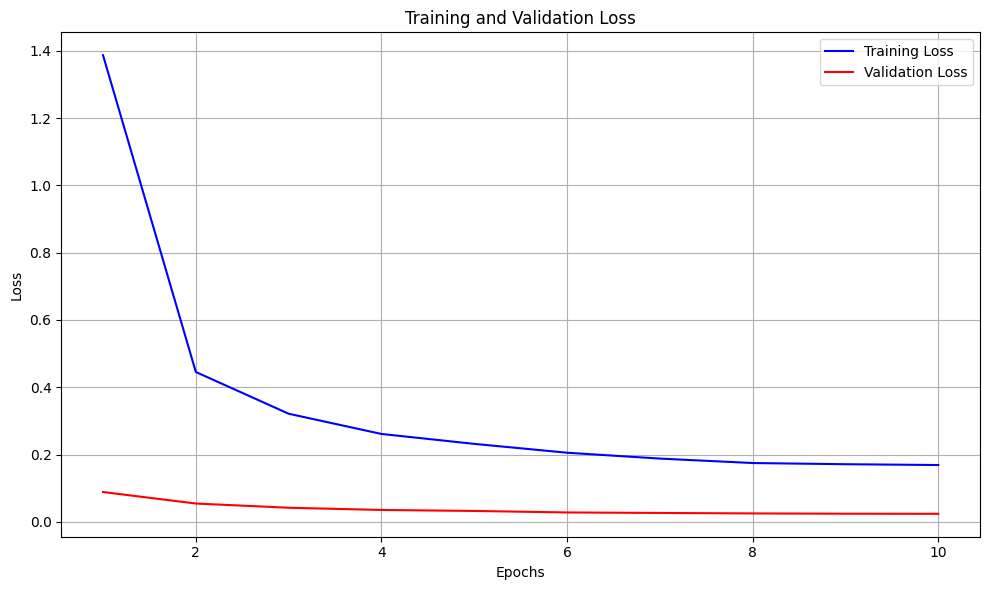

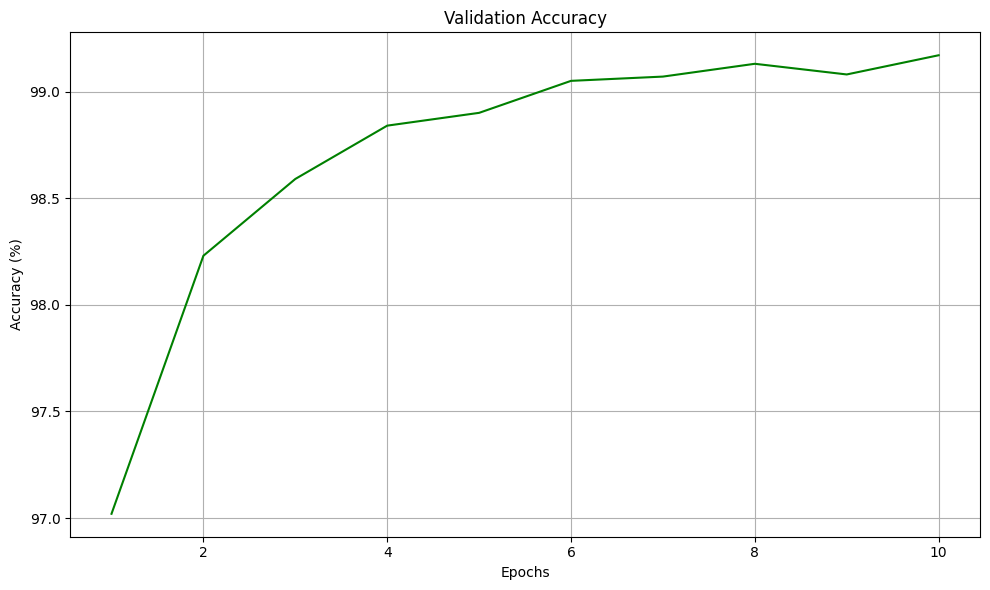

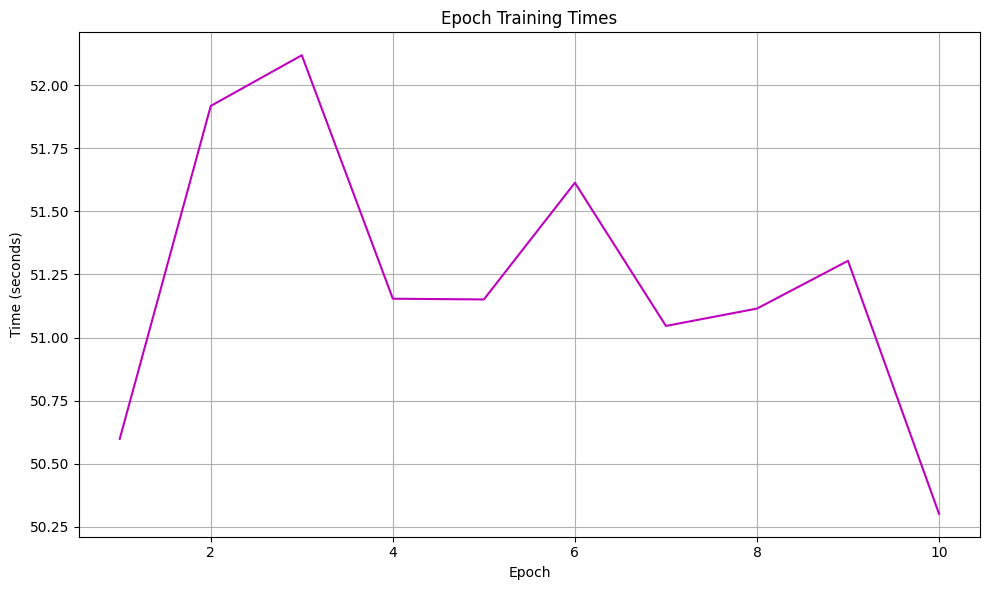

In [4]:
# set random seed for reproducibility
torch.manual_seed(42)

# check for gpu availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')

# define transformations for training set with augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# define transformations for test set without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load mnist dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

# create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, pin_memory=True)

# create FNN model
# input_size = 28 * 28  # MNIST images are 28x28 pixels
# hidden_size = [128]  # one hidden layer
# output_size = 10  # 10 classes (digits 0-9)
# model = Perceptron(
#     input_size=input_size,
#     hidden_size=hidden_size,
#     output_size=output_size,
#     softmax_dim=-1
# )

# define regularization hyperparameters
dropout_rate = 0.5
weight_decay = 1e-4

# create CNN model
input_channels = 1
num_classes = 10
model = CNNLayer(input_channels, num_classes, dropout_rate, weight_decay)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# create a learning rate scheduler for overfitting
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,
    eta_min=1e-6
)

# create our trainer
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,  # using test set as validation set
    device=device,
    scheduler=scheduler,
    checkpoint_dir='./checkpoints',
    experiment_name="MNIST_CNN_Model"
)

# train the model
history = trainer.train(
    num_epochs=10,
    log_to_mlflow=True,
    early_stopping_patience=5  # enable early stopping for overfitting
)

# uncomment to resume training from a checkpoint
# don't forget to change the checkpoint path
# checkpoint_path = './checkpoints/checkpoint_epoch_2.pt'
# start_epoch = trainer.load_checkpoint(checkpoint_path)
# trainer.train(num_epochs=10, start_epoch=start_epoch)

# uncomment to use the best model for inference
# trainer.load_checkpoint('./checkpoints/best_model.pt')
